In [25]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
from catboost import CatBoostRegressor
import scipy as sp
from scipy.fftpack import fft
from tsfresh.feature_extraction import feature_calculators

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense

from scipy import signal

import gc
%matplotlib inline

In [26]:
def load_extracted_features(features_file):
    train_X = pd.read_csv(os.path.join("../extracted_feat/",features_file))
    train_y = pd.read_csv(os.path.join("../extracted_feat/",'train_y_11.csv'))
    return train_X,train_y
def load_extracted_test(features_file):
    segment_names = [file[:-4] for file in os.listdir("../input") if file.startswith("seg")]
    test_df = pd.read_csv(os.path.join("../extracted_feat/",features_file))
    test_df.index = segment_names
    return test_df

In [27]:
train_X,train_y = load_extracted_features("train_x_94.csv")
test_df = load_extracted_test("test_94.csv")

In [28]:
#eliminate quakes from training
quakes = (train_y["time_to_failure"] - train_y["time_to_failure"].shift())>0.5

train_y_eliminated = train_y[~quakes].copy()
train_X_eliminated = train_X[~quakes].copy()

In [29]:
eq_groups = train_y.copy()
eq_groups["group"] = 0
eq_groups.loc[quakes,"group"] += 1
eq_groups["group"] = eq_groups["group"].cumsum()
eq_groups.drop(columns=["time_to_failure"],inplace=True)
eq_groups = eq_groups[~quakes].values
eq_groups = eq_groups.reshape(eq_groups.shape[0],)

In [30]:
scaler = StandardScaler()
scaler.fit(train_X_eliminated)
train_X_scaled = pd.DataFrame(scaler.transform(train_X_eliminated),columns=train_X_eliminated.columns)
test_df_scaled = pd.DataFrame(scaler.transform(test_df),columns=test_df.columns,index=test_df.index)

In [31]:

def train(train_X,train_y,test_df,params):
    group_kfold = LeaveOneGroupOut()
#     group_kfold = GroupKFold(n_splits=8)
    fold_splitter = group_kfold.split(train_X, train_y,eq_groups)

    features_importance = pd.DataFrame({"features":train_X.columns,
                                            "importance":np.zeros(train_X.columns.shape[0])})
    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])

    for group_out, (train_idx,val_idx) in enumerate(fold_splitter):
        print("-- group " + str(group_out) +"--")
        #shuffle
        
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
        
        model = lgb.LGBMRegressor(**params, n_estimators = 20000,n_jobs=-1)
        model.fit(X_train,y_train,
                  eval_set=[(X_train,y_train),(X_val,y_val)], 
                  verbose=1000,
                  early_stopping_rounds=1000)

        oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

        features_importance["importance"] += model.feature_importances_
        predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_)
    return oof,predictions,features_importance


In [32]:
params = {'lambda_l1': 0.034590573608641643, 'bagging_freq': 18, 'verbose': -1, 'min_data_in_leaf': 4, 'feature_fraction': 0.4316230190416108, 'objective': 'MAE', 'lambda_l2': 0.03793022878062269, 'metric': 'MAE', 'bagging_fraction': 0.6887668514176042, 'max_depth': -1, 'learning_rate': 0.003885750234809167, 'boosting_type': 'gbdt', 'num_leaves': 40}
oof_lgb,predictions_lgb,features_importance = train(train_X_scaled,train_y_eliminated,test_df_scaled,params)

-- group 0--
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.64142	valid_1's l1: 3.33648
[2000]	training's l1: 1.43178	valid_1's l1: 3.3618
Early stopping, best iteration is:
[1130]	training's l1: 1.60668	valid_1's l1: 3.32357
-- group 1--
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.66867	valid_1's l1: 1.62744
[2000]	training's l1: 1.44008	valid_1's l1: 1.51408
[3000]	training's l1: 1.2847	valid_1's l1: 1.47335
[4000]	training's l1: 1.16837	valid_1's l1: 1.45806
[5000]	training's l1: 1.06347	valid_1's l1: 1.45911
Early stopping, best iteration is:
[4361]	training's l1: 1.12914	valid_1's l1: 1.45534
-- group 2--
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.56528	valid_1's l1: 2.9199
[2000]	training's l1: 1.35859	valid_1's l1: 2.87472
[3000]	training's l1: 1.21877	valid_1's l1: 2.84312
[4000]	training's l1: 1.10495	valid_1's l1: 2.81828
[5000]	training's l1: 1.01

In [33]:
def train_cat(train_X,train_y,test_df):
    group_kfold = LeaveOneGroupOut()
    fold_splitter = group_kfold.split(train_X_eliminated, train_y_eliminated,eq_groups)

    features_importance = pd.DataFrame({"features":train_X.columns,
                                            "importance":np.zeros(train_X.columns.shape[0])})
    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])
    
    params = {'loss_function':'MAE'}
    for group_out, (train_idx,val_idx) in enumerate(fold_splitter):
        print("-- group " + str(group_out) +"--")
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]

        model = CatBoostRegressor(iterations=10000,  eval_metric='MAE', **params)
        model.fit(X_train,y_train,
                    eval_set=[(X_train,y_train),(X_val,y_val)], 
                    verbose=4000,
                    early_stopping_rounds=700,use_best_model=True)

        oof[val_idx] = model.predict(X_val)

        features_importance["importance"] += model.feature_importances_
        predictions["time_to_failure"] += model.predict(test_df)
    return oof,predictions,features_importance
oof_cat,predictions_cat,features_importance = train_cat(train_X_scaled,train_y_eliminated,test_df_scaled)

-- group 0--
0:	learn: 5.6926515	test: 5.6926515	test1: 0.7144494	best: 0.7144494 (0)	total: 78ms	remaining: 12m 59s
Stopped by overfitting detector  (700 iterations wait)

bestTest = 0.3424736751
bestIteration = 52

Shrink model to first 53 iterations.
-- group 1--
0:	learn: 5.6410348	test: 5.6410348	test1: 5.7485542	best: 5.7485542 (0)	total: 21.5ms	remaining: 3m 34s
4000:	learn: 1.8020374	test: 1.8020374	test1: 1.6881114	best: 1.6881114 (4000)	total: 1m 25s	remaining: 2m 8s
8000:	learn: 1.6568316	test: 1.6568316	test1: 1.6396665	best: 1.6394332 (7977)	total: 2m 52s	remaining: 43s
9999:	learn: 1.5988247	test: 1.5988247	test1: 1.6179752	best: 1.6178686 (9966)	total: 3m 35s	remaining: 0us

bestTest = 1.61786855
bestIteration = 9966

Shrink model to first 9967 iterations.
-- group 2--
0:	learn: 5.5133071	test: 5.5133071	test1: 7.0710599	best: 7.0710599 (0)	total: 22.8ms	remaining: 3m 47s
4000:	learn: 1.6754026	test: 1.6754026	test1: 3.0114271	best: 3.0111296 (3838)	total: 1m 26s	remaini

In [34]:
def train_lr(train_X,train_y,test_df):
    group_kfold = LeaveOneGroupOut()
    fold_splitter = group_kfold.split(train_X_eliminated, train_y_eliminated,eq_groups)

    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])
    
    for group_out, (train_idx,val_idx) in enumerate(fold_splitter):
        print("-- group " + str(group_out) +"--")
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]

        model = LinearRegression()
        model.fit(X_train,y_train)

        oof[val_idx] = model.predict(X_val).reshape(len(X_val),)

        predictions["time_to_failure"] += model.predict(test_df).reshape(len(test_df),)
    return oof,predictions
oof_lr,predictions_lr= train_lr(train_X_scaled,train_y_eliminated,test_df_scaled)

-- group 0--
-- group 1--
-- group 2--
-- group 3--
-- group 4--
-- group 5--
-- group 6--
-- group 7--
-- group 8--
-- group 9--
-- group 10--
-- group 11--
-- group 12--
-- group 13--
-- group 14--
-- group 15--
-- group 16--


In [35]:
def seq_model():
    model = Sequential()
    model.add(Dense(32,input_shape = (train_X_scaled.shape[1],),activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mae',optimizer = 'adam')
    return model
def train_nn(train_X,train_y,test_df):
    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])
    group_kfold = LeaveOneGroupOut()
    fold_splitter = group_kfold.split(train_X_eliminated, train_y_eliminated,eq_groups)
    for group_out, (train_idx,val_idx) in enumerate(fold_splitter):
        print("-- group " + str(group_out) +"--")
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]

        model = seq_model()
        mcp_save = ModelCheckpoint('.mdl_wtsPL.hdf5', save_best_only=True, monitor='val_loss', mode='min',verbose=2)
        model.fit(X_train,y_train,
                  validation_data=(X_val,y_val), 
                  verbose=2,epochs=50,callbacks=[mcp_save])
        model.load_weights(filepath = '.mdl_wtsPL.hdf5')
        
        oof[val_idx] = model.predict(X_val).reshape(len(X_val),)

        predictions["time_to_failure"] += model.predict(test_df).reshape(len(test_df),)
    return oof,predictions

oof_nn,predictions_nn = train_nn(train_X_scaled,train_y,test_df_scaled)

-- group 0--
Train on 4141 samples, validate on 37 samples
Epoch 1/50
 - 3s - loss: 3.2561 - val_loss: 3.0409

Epoch 00001: val_loss improved from inf to 3.04089, saving model to .mdl_wtsPL.hdf5
Epoch 2/50
 - 0s - loss: 2.3077 - val_loss: 3.3152

Epoch 00002: val_loss did not improve from 3.04089
Epoch 3/50
 - 0s - loss: 2.2485 - val_loss: 3.5270

Epoch 00003: val_loss did not improve from 3.04089
Epoch 4/50
 - 0s - loss: 2.2415 - val_loss: 3.1863

Epoch 00004: val_loss did not improve from 3.04089
Epoch 5/50
 - 0s - loss: 2.2032 - val_loss: 3.2030

Epoch 00005: val_loss did not improve from 3.04089
Epoch 6/50
 - 0s - loss: 2.1977 - val_loss: 3.2060

Epoch 00006: val_loss did not improve from 3.04089
Epoch 7/50
 - 0s - loss: 2.1953 - val_loss: 3.2337

Epoch 00007: val_loss did not improve from 3.04089
Epoch 8/50
 - 0s - loss: 2.1766 - val_loss: 3.0932

Epoch 00008: val_loss did not improve from 3.04089
Epoch 9/50
 - 0s - loss: 2.1750 - val_loss: 3.1020

Epoch 00009: val_loss did not im

In [36]:
mean_absolute_error(train_y_eliminated,oof_cat)

1.9135276462598823

In [37]:
mean_absolute_error(train_y_eliminated,oof_lgb)

2.014342074056911

In [38]:
mean_absolute_error(train_y_eliminated,oof_lr)

2.276329799179306

In [43]:
mean_absolute_error(train_y_eliminated,oof_nn)

1.9153186389216783

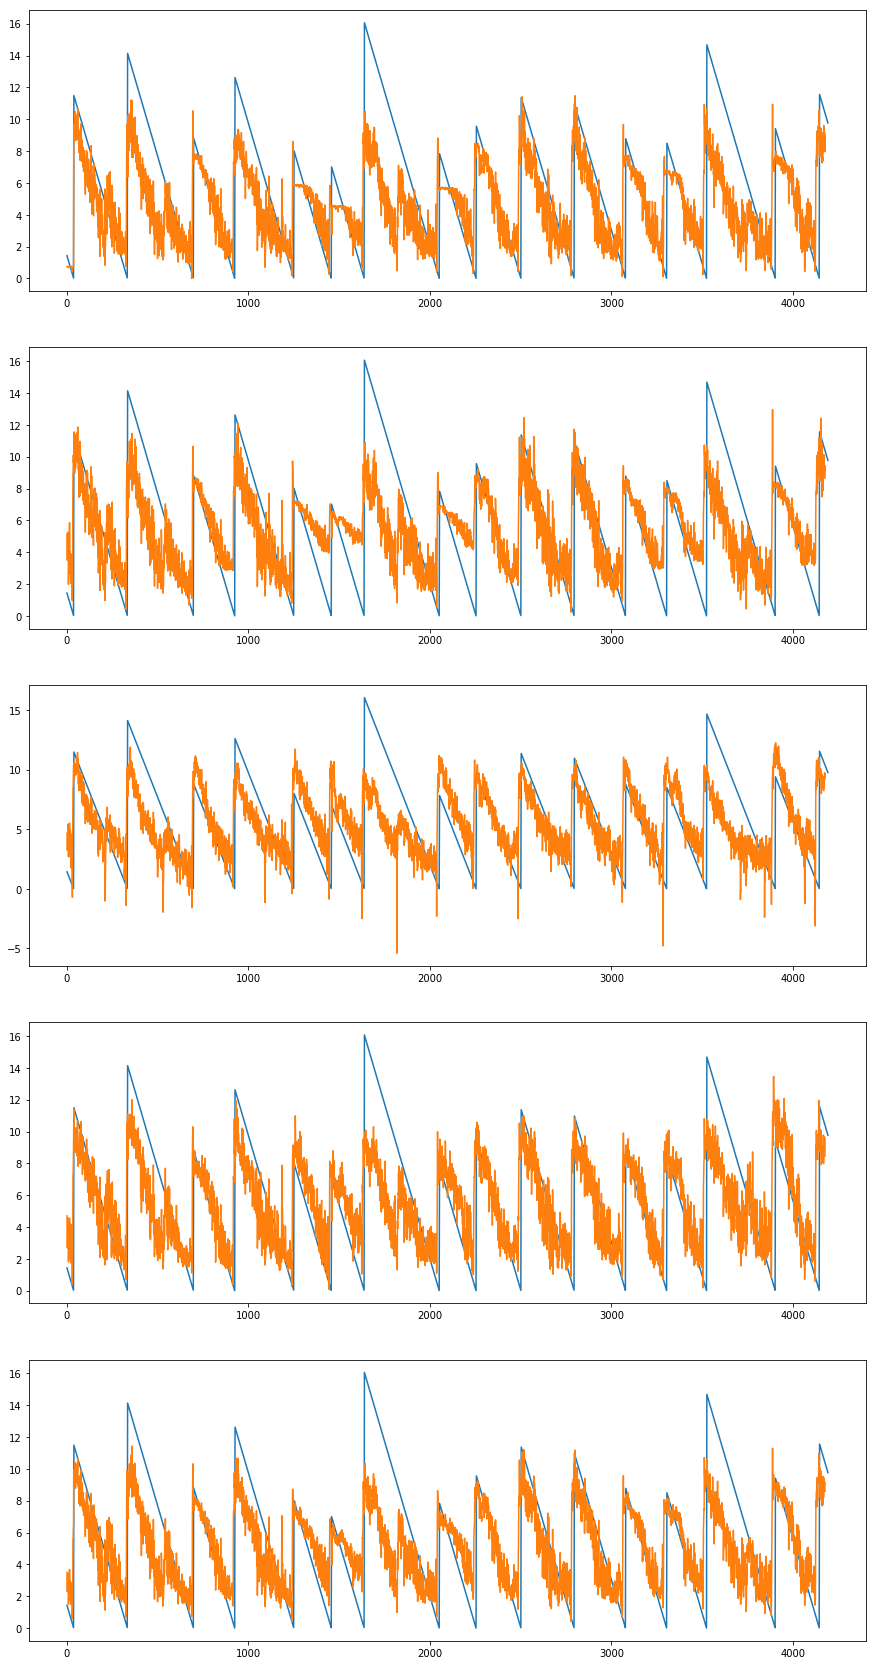

In [50]:
blended = oof_cat*0.33 + 0.33*oof_lgb + 0.33*oof_nn
fig, ax = plt.subplots(5,1,figsize=(15,30))
ax[0].plot(train_y_eliminated)
ax[0].plot(oof_cat)
ax[1].plot(train_y_eliminated)
ax[1].plot(oof_lgb)
ax[2].plot(train_y_eliminated)
ax[2].plot(oof_lr)
ax[3].plot(train_y_eliminated)
ax[3].plot(oof_nn)
ax[4].plot(train_y_eliminated)
ax[4].plot(blended)

In [52]:
#save solutions
import datetime
now = datetime.datetime.now()

final_pred_lgb = predictions_lgb.copy()
final_pred_lgb["time_to_failure"] = predictions_lgb["time_to_failure"]/16
final_pred_lgb["seg_id"] = test_df.index
final_pred_lgb.to_csv("../submissions/quakewise/lgb_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

final_pred_cat = predictions_cat.copy()
final_pred_cat["time_to_failure"] = predictions_cat["time_to_failure"]/16
final_pred_cat["seg_id"] = test_df.index
final_pred_cat.to_csv("../submissions/quakewise/cat_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

final_pred_lr = predictions_lr.copy()
final_pred_lr["time_to_failure"] = predictions_lr["time_to_failure"]/16
final_pred_lr["seg_id"] = test_df.index
final_pred_lr.to_csv("../submissions/quakewise/lr_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

final_pred_nn = predictions_nn.copy()
final_pred_nn["time_to_failure"] = predictions_nn["time_to_failure"]/16
final_pred_nn["seg_id"] = test_df.index
final_pred_nn.to_csv("../submissions/quakewise/nn_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

In [54]:
#mask {reg_scaled_nr-features_date.csv}
pd.DataFrame(oof_cat).to_csv("../oof/quakewise/cat_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)
pd.DataFrame(oof_lgb).to_csv("../oof/quakewise/lgb_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)
pd.DataFrame(oof_lr).to_csv("../oof/quakewise/lr_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)
pd.DataFrame(oof_nn).to_csv("../oof/quakewise/nn_sc_17_"+now.strftime("%d-%m-%H-%M")+".csv",index=False)

In [ ]:
train_y_eliminated.to_csv("../submissions/quakewise/train_y_eliminated.csv",index=False)

In [51]:
mean_absolute_error(train_y_eliminated,blended)

1.8840366109125615

In [ ]:
train